In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict, qualitycheck_trials, find_nearest_ind
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib widget

#### Load excel sheet with metadata for experiments

### Load subject

In [5]:
data_loc = r"M:\temp_data\mouse644565\signal_test_2022-11-30_15-41-47\experiment1\recording1"

In [6]:
exp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print('{} - {}'.format(exp.mouse, exp_tag))

No *stim* files were found.
Experiment type: spontaneous
644565 - signal_test


Load stim log

In [12]:
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
stim_log.head()

,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
0,freq50Hz,0,biphasic,10,1356.93868,1356.93908,0.0004,0
1,freq50Hz,0,biphasic,10,1356.95868,1356.95908,0.0004,0
2,freq50Hz,0,biphasic,10,1356.97868,1356.97908,0.0004,0
3,freq50Hz,0,biphasic,10,1356.99868,1356.99908,0.0004,0
4,freq50Hz,0,biphasic,10,1357.01868,1357.01908,0.0004,0


Load EEG all event traces

In [8]:
all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
good_chs = np.array([x for x in eeg_chs if x not in bad_chs])
print(len(good_chs))

FileNotFoundError: [Errno 2] No such file or directory: 'P:\\mouse771425\\THstim_d2_2024-11-22_10-49-58\\experiment1\\recording1\\evoked_data\\event_EEGtraces.npy'

Load and plot running and pupil

In [9]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

In [7]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    # pupildf.head()

    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    eyeD = pupildf.Eye_Diameter.values

else:
    print('No local Pupileye*.csv file. Check server.')

Text(0.5, 0, 'Pixels')

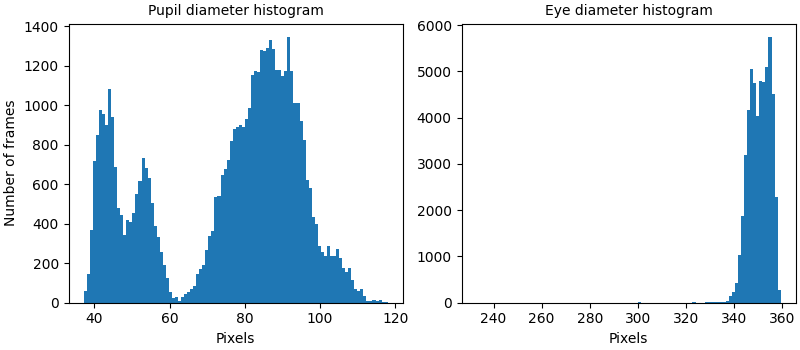

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8,3.5), constrained_layout=True)

axs[0].hist(pupilD, bins=100)
axs[0].set_title('Pupil diameter histogram')
axs[0].set_ylabel('Number of frames')
axs[0].set_xlabel('Pixels')

axs[1].hist(eyeD, bins=100)
axs[1].set_title('Eye diameter histogram')
axs[1].set_xlabel('Pixels')

## Smoothing the eye diameter

In [9]:
## Smooth eye diameter ##
smooth_eyeD = np.zeros_like(eyeD)
k = 50 # filter window is actually k*2+1
for i in range(k, len(eyeD)-k-1):
    smooth_eyeD[i] = np.mean(eyeD[i-k:i+k]) # each point is the average of k surrounding points
smooth_eyeD[:k] = eyeD[:k]
smooth_eyeD[-k-1:] = eyeD[-k-1:]

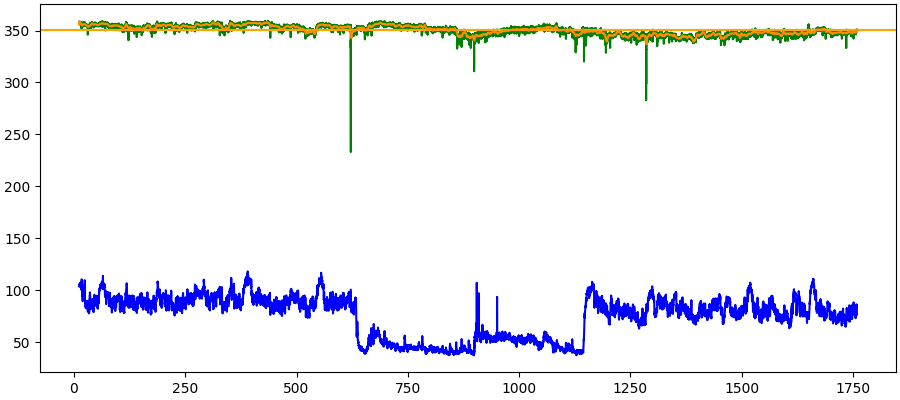

In [10]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

ax.plot(pupilts, pupilD, 'b')
ax.plot(pupilts, eyeD, 'g')
ax.axhline(np.mean(eyeD), color='c')
ax.axhline(np.median(eyeD), color='orange')
ax.plot(pupilts, smooth_eyeD, 'darkorange')

## Testing different normalizations

In [16]:
## pupil diameter / smoothed eye diameter
normpupil1 = pupilD / smooth_eyeD

## pupil diameter / mean eye diameter
normpupil2 = pupilD / np.mean(eyeD)

## smooth pupil diameter, then normalize ##
smooth_pup = np.zeros_like(pupilD)
k = 5 # filter window is actually k*2+1
for i in range(k, len(pupilD)-k-1):
    smooth_pup[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
smooth_pup[:k] = pupilD[:k]
smooth_pup[-k-1:] = pupilD[-k-1:]
normpupil3 = smooth_pup / np.mean(eyeD)

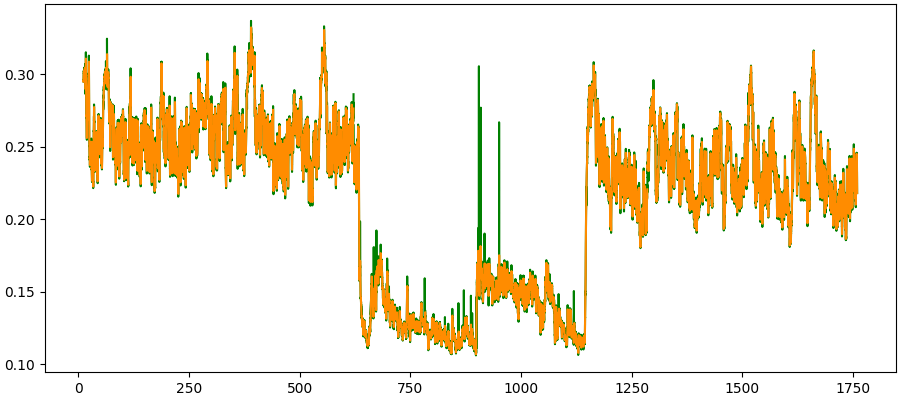

In [17]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

# ax.plot(pupilts, normpupil1, 'b')
ax.plot(pupilts, normpupil2, 'g')
ax.plot(pupilts, normpupil3, 'darkorange')

NameError: name 'speedts' is not defined

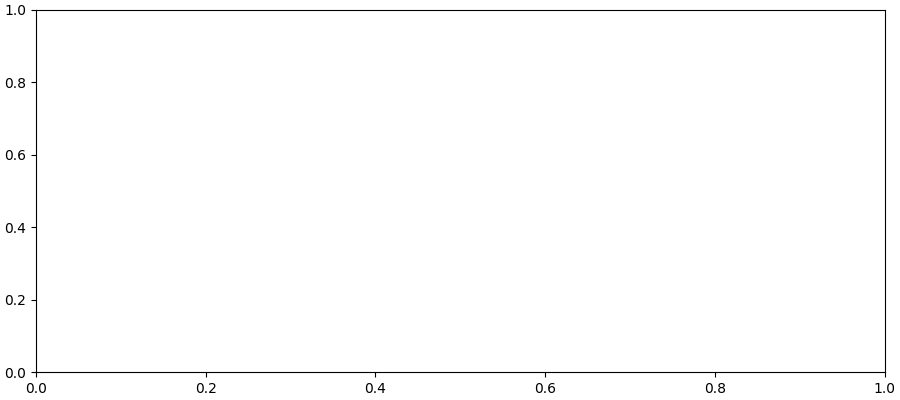

In [17]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

if inj_times is not None:
    for itime in inj_times:
        ax.axvline(itime/60, color='k', linestyle='dashed')

ax.plot(speedts/60, speed, 'seagreen', alpha=0.8)
ax.set_xlim([speedts[0]/60, speedts[-1]/60])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (cm/s)', color='seagreen')
ax.tick_params(axis='y', labelcolor='seagreen')
ax.set_ylim([0, 100])

ax2 = ax.twinx()
if normpupil is not None:
    ax2.plot(pupilts/60, normpupil, 'm', alpha=0.8)
    ax2.set_ylabel('Normalized pupil diameter', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
ax2.set_ylim([0, 1])

## add stim times to plot ##
# for etype, ecol in zip(['biphasic', 'circle'], ['orange', 'blue']):
for rboo, rcol in zip([True, False], ['orange', 'green']):
    stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
    ax2.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)